# Tarea 1 IMT2112 - Clemente Wacquez
---


### Pregunta 1
El cuaderno compilado se encuentra adjunto como `ejecucion.ipynb`. Se utilizaron 20.000 registros y $k=7$

---

### Pregunta 2 
El código presentado no tiene ninguna implementación de paralelismo. Esto puede deducirse dado que python no puede realizar paralelismo con sus librerias estándar y no se importa ninguna librería adicional que permita realizar paralelismo en el código.

---

### Pregunta 3
Copiamos las celdas que nos permiten generar los datos

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
from sklearn.datasets import make_blobs
n_points = 20_000
n_clusters = 3
np.random.seed(0)
dataset, _ = make_blobs(n_samples=n_points, n_features=2, centers=n_clusters)
print("Created a dataset that represents", n_clusters, "clusters in", dataset.shape[1], "dimensions.")

Created a dataset that represents 3 clusters in 2 dimensions.


In [3]:
k = 7
centers = np.zeros([k, 2])
for c in range(k):
    centers[c,0] = float(c+1)/(k+1)
    centers[c,1] = 0.0

max_iterations = 1000

A continuación, definiremos dos funciones: `k_medidas` y `k_medidas_numpy`, la primera corresponde a la implementación del algoritmo de $k$-medidas que se entregó de ejemplo y la segunda la reimplementación utilizando funciones de la librería `numpy` . Las porciones con código modificado se encuentran comentadas con `##`.

In [4]:
def k_medias(data, k, verbosity=False):
    
    centers = np.zeros([k, 2])
    for c in range(k):
        centers[c,0] = float(c+1)/(k+1)
        centers[c,1] = 0.0
    
    max_iterations = 1000
    
    # store the history of centers and clusters
    history_of_centers = [centers]
    history_of_clusters = []
    
    for iteration in range(max_iterations):
        
        old_centers = history_of_centers[-1]
    
        # assignment step
        cluster = np.zeros(n_points, dtype='int')
        for p in range(n_points):
            minimum_distance = np.inf
            nearest_cluster = None
            for c in range(k):
                distance_to_cluster_c = np.sqrt((data[p,0] - old_centers[c,0])**2 + (data[p,1] - old_centers[c,1])**2)
                if distance_to_cluster_c < minimum_distance:
                    minimum_distance = distance_to_cluster_c
                    nearest_cluster = c
            cluster[p] = nearest_cluster
        history_of_clusters.append(cluster)
        
        # check convergence
        if iteration > 0:
            clusters_changed = False
            for p in range(n_points):
                if history_of_clusters[-1][p] != history_of_clusters[-2][p]:
                    clusters_changed = True
            if not clusters_changed:
                if verbosity:
                    print("Converged in", iteration, "iterations.\n")
                break
    
        # update step
        number_of_points_in_cluster = np.zeros(k, dtype='int')
        sum_of_locations = np.zeros([k, 2], dtype='float')
        for p in range(n_points):
            number_of_points_in_cluster[cluster[p]] += 1
            sum_of_locations[cluster[p], :] += data[p, :]
        new_centers = np.zeros([k, 2], dtype='float')
        for c in range(k):
            new_centers[c,0] = sum_of_locations[c,0] / number_of_points_in_cluster[c]
            new_centers[c,1] = sum_of_locations[c,1] / number_of_points_in_cluster[c]
        history_of_centers.append(new_centers)
    
    if iteration == max_iterations-1:
        if verbosity:
            print("The algorithm did not converge in", max_iterations, "iterations.")

    else:
        return history_of_clusters[-1], history_of_centers[-1]

In [5]:
def k_medias_numpy(data, k, verbosity=False):
    
    centers = np.zeros([k, 2])
    for c in range(k):
        centers[c,0] = float(c+1)/(k+1)
        centers[c,1] = 0.0
    
    max_iterations = 1000
    
    # store the history of centers and clusters
    ## Cambiamos los tipos de los historiales a np.array
    history_of_centers = np.array([centers])
    history_of_clusters = np.empty((0, n_points))
    
    for iteration in range(max_iterations):
        
        old_centers = history_of_centers[-1]
    
        # assignment step
        ## Calculamos las distancias que hay entre los registros y los centros utilizando cdist
        dist_matrix = cdist(data, old_centers)

        ## Obtenemos el array `cluster` calculando los índices en que se encuentra el mínimo de
        ## cada fila de la matriz `dist_matrix`
        cluster = np.argmin(dist_matrix, axis = 1)
        
        history_of_clusters = np.vstack([history_of_clusters, cluster])
    
        if iteration > 0:
            clusters_changed = False
            ## Chequeamos si los clusters cambiaron utilizando np.array_equal
            if not np.array_equal(history_of_clusters[-1], history_of_clusters[-2]):
                clusters_changed = True
            if not clusters_changed:
                if verbosity:
                    print("Converged in", iteration, "iterations.\n")
                break
    
        # update step
        ## Eliminamos el loop utilizando la función np.mean y el hecho que el arreglo `cluster==center`
        ## nos entregará los valores en el data que pertenecen al centro `center`
        new_centers = np.array([np.mean(data[cluster == center], axis=0) for center in range(k)])
        history_of_centers = np.append(history_of_centers, [new_centers], axis=0)
    
    if iteration == max_iterations-1:
        if verbosity:
            print("The algorithm did not converge in", max_iterations, "iterations.")
    else:
        return history_of_clusters[-1], history_of_centers[-1]

---

### Pregunta 4
#### Comparación de tiempos
Sin `numpy`:

In [6]:
%%time
k_medias(dataset, k, True)

Converged in 69 iterations.

CPU times: user 47.9 s, sys: 24.6 ms, total: 48 s
Wall time: 48.1 s


(array([5, 2, 0, ..., 6, 6, 6], shape=(20000,)),
 array([[-2.42643815,  3.16739782],
        [-0.4525531 ,  4.1582162 ],
        [-1.12449342,  2.0582954 ],
        [ 1.40197533,  4.92862   ],
        [ 1.45500616,  0.35161267],
        [ 1.41441328,  2.92325992],
        [ 2.9391587 ,  1.05490536]]))

Con `numpy`

In [7]:
%%time
k_medias_numpy(dataset, k, True)

Converged in 69 iterations.

CPU times: user 547 ms, sys: 56.2 ms, total: 603 ms
Wall time: 606 ms


(array([5., 2., 0., ..., 6., 6., 6.], shape=(20000,)),
 array([[-2.42643815,  3.16739782],
        [-0.4525531 ,  4.1582162 ],
        [-1.12449342,  2.0582954 ],
        [ 1.40197533,  4.92862   ],
        [ 1.45500616,  0.35161267],
        [ 1.41441328,  2.92325992],
        [ 2.9391587 ,  1.05490536]]))

a) El código no corre ninguna parte en paralelo, incluso las funciones de `numpy` y `scipy` utilizadas corren en un solo hilo. [referencia](google.com).

b) La diferencia de tiempos observadas en el sistema en que se corrió este código fue de 42.35 segundos. La implementación con `numpy` fué más de 7 veces más rápida que la original.

---

### Pegunta 5
#### a)
Definimos una función para calcular la dispersión dado el output de las funciones definidas en las celdas anteriores. Se asume que 

In [8]:
def dispersion(data, clusters, centers):
    pass

In [9]:
def calc_dispersion(data, k):
    print(k, end=" ")
    cluster, centers = k_medias_numpy(data, k)
    dispersion = 0.0
    for i in range(centers.shape[0]):
        dispersion += np.sum( np.linalg.norm( data[cluster==i, :] - centers[i,:], axis=1 ) )
    return dispersion

#### b)
Ahora graficamos la dispersión para distintos valores de $k$:

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

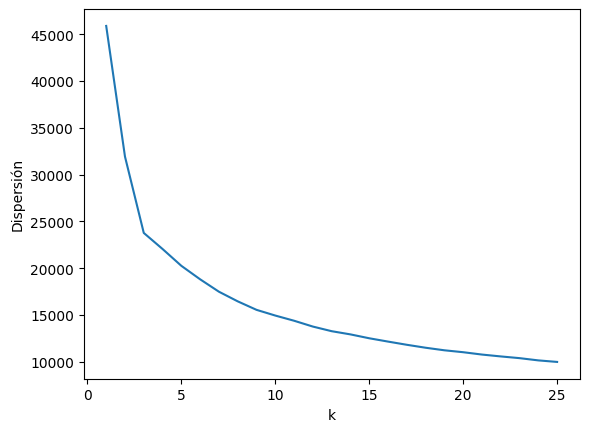

CPU times: user 24.7 s, sys: 592 ms, total: 25.3 s
Wall time: 25.4 s


In [10]:
%%time
import matplotlib.pyplot as plt
max_k = 25
x = [i for i in range(1, max_k + 1)]
y = [calc_dispersion(dataset, i) for i in range(1, max_k + 1)]
plt.plot(x,y)
plt.xlabel("k")
plt.ylabel("Dispersión")
plt.show()

#### c)
Ahora, utilizamos la librería`joblib`para hacer estos 25 cálculos en procesos paralelos

In [11]:
from joblib import Parallel, delayed

In [12]:
disperssions_numpy = [delayed(k_medias_numpy)(dataset, k) for k in range(1, 25)]

In [13]:
%%time
batch_size = 'auto'
n_jobs = -1
with Parallel(n_jobs=n_jobs, batch_size=batch_size, backend='loky') as parallel_pool:
    parallel_results = parallel_pool(disperssions_numpy)

CPU times: user 160 ms, sys: 42.7 ms, total: 203 ms
Wall time: 12.7 s


---
### Pregunta 6
#### a)
Mi computador tiene


In [14]:
from joblib import cpu_count
print(cpu_count())

4


núcleos.
#### b y d)
A continuación se presenta un script que mide el tiempo de ejecución de los dos 

In [15]:
disperssions_no_numpy = [delayed(k_medias)(dataset, k) for k in range(1, 25)]

n_jobs 1: 22.725048542022705
n_jobs 2: 14.686956644058228
n_jobs 3: 13.551239967346191
n_jobs 4: 11.863122940063477
n_jobs 5: 11.635244131088257
n_jobs 6: 10.948320865631104
n_jobs 7: 11.573101282119751
n_jobs 8: 10.830377101898193


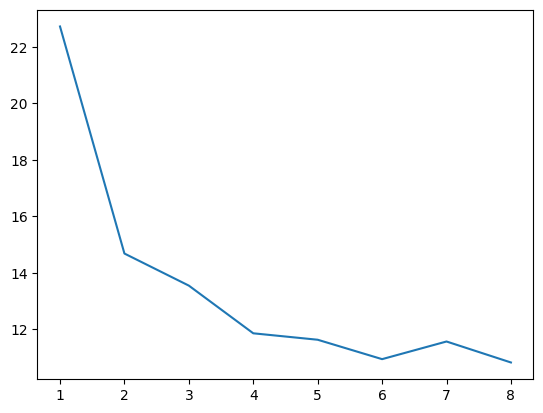

CPU times: user 23.4 s, sys: 369 ms, total: 23.8 s
Wall time: 1min 47s


In [16]:
%%time
from time import time
times_no_numpy, times_numpy = [], []
jobs = [j for j in range(1, 9)]
for j in jobs:
    #print("n_jobs:", n_jobs)
    #print("no numpy")
    #start_no_numpy = time()
    #with Parallel(n_jobs=n_jobs, batch_size=batch_size, backend='loky') as parallel_pool:
    #    parallel_results = parallel_pool(disperssions_no_numpy)
    #end_no_numpy = time() 
    #times_no_numpy.append(end_no_numpy - start_no_numpy)
    
    print("n_jobs", j, end=": ")
    start_numpy = time()
    with Parallel(n_jobs=j, backend='loky') as parallel_pool:
        parallel_results = parallel_pool(disperssions_numpy)
    end_numpy = time() 
    total = end_numpy - start_numpy
    times_numpy.append(total)
    print(total)

#plt.plot(jobs, times_no_numpy)
plt.plot(jobs, times_numpy)

plt.show()
    